In [1]:
import numpy as np
import cupy as cp
from holotomocupy.holo import G, GT
from holotomocupy.shift import S, ST
from holotomocupy.chunking import gpu_batch
from holotomocupy.recon_methods import CTFPurePhase, multiPaganin
from holotomocupy.proc import dai_yuan, linear
import holotomocupy.chunking as chunking
from holotomocupy.utils import *
import h5py
from holotomocupy.proc import remove_outliers




astropy module not found
olefile module not found


# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 2048  # object size in each dimension

npos = 16  # number of code positions
detector_pixelsize = 3.03751e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:1]-sx0
z1 = np.tile(z1, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnifications[0]*2048/n)  # object voxel size
# allow padding if there are shifts of the probe
pad = n//8
# sample size after demagnification
ne = n+2*pad

show = True

flg = f'1'
path = f'/data/vnikitin/ESRF/ID16A/SiemensLH_33keV_010nm_holoNfpScan_01/'

## Read data

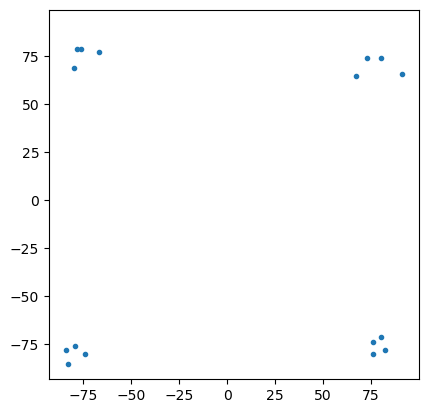

In [3]:
nref = 20
ndark = 20
data00 = np.zeros([1,npos,n,n],dtype='float32')
ref00 = np.zeros([nref,n,n],dtype='float32')
dark00 = np.zeros([ndark,n,n],dtype='float32')
with h5py.File(f'{path}SiemensLH_33keV_010nm_holoNfpScan_010000.h5','r') as fid:
    data00[:] = fid['/entry_0000/measurement/data'][:npos][np.newaxis]
with h5py.File(f'{path}/ref_0000.h5','r') as fid:
    ref00[:]=fid['/entry_0000/measurement/data'][:nref]
with h5py.File(f'{path}/dark_0000.h5','r') as fid:
    dark00[:]=fid['/entry_0000/measurement/data'][:ndark]
with h5py.File(f'{path}SiemensLH_33keV_010nm_holoNfpScan_010000.h5','r') as fid:
    spz = np.array(str(np.array(str(np.array(fid['/entry_0000/instrument/PCIe/header/spz']))[1:]))[1:-1].split(' '),dtype='float32')*1e-6/voxelsize
    spy = np.array(str(np.array(str(np.array(fid['/entry_0000/instrument/PCIe/header/spy']))[1:]))[1:-1].split(' '),dtype='float32')*1e-6/voxelsize

plt.plot(spy,spz,'.')
plt.axis('square')
plt.show()
shifts_code = np.zeros([1,npos,2],dtype='float32')
shifts_code[:,:,1] = spy
shifts_code[:,:,0] = -spz


# remove outliers

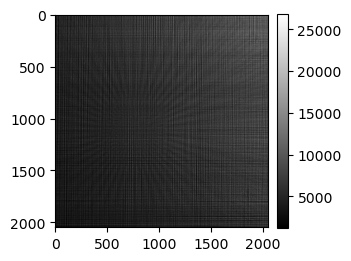

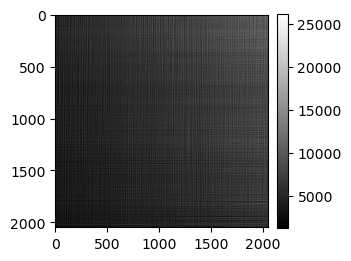

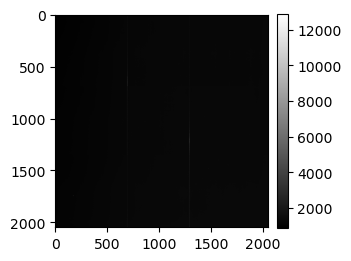

In [4]:
for k in range(npos):
    radius = 7
    threshold = 20000
    data00[:,k] = remove_outliers(data00[:,k], radius, threshold)
ref00[:] = remove_outliers(ref00[:], radius, threshold)     
dark00[:] = remove_outliers(dark00[:], radius, threshold)     


mshow(data00[0,0],show)
mshow(ref00[0],show)
mshow(dark00[0],show)

# normalize

In [5]:
data00-=np.mean(dark00)
ref00-=np.mean(dark00)

data00[data00<=0] = 0
ref00[ref00<=0] = 0

data00/=np.mean(ref00)
ref00/=np.mean(ref00)

rdata = (data00-np.mean(dark00,axis=0))/(np.mean(ref00,axis=0)-np.mean(dark00,axis=0))

# check shifts by moving images back to the center

/tmp/ipykernel_1231846/3648330653.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  rdata[:,k] = ST(rdata[:,k],shifts_code[:,k])


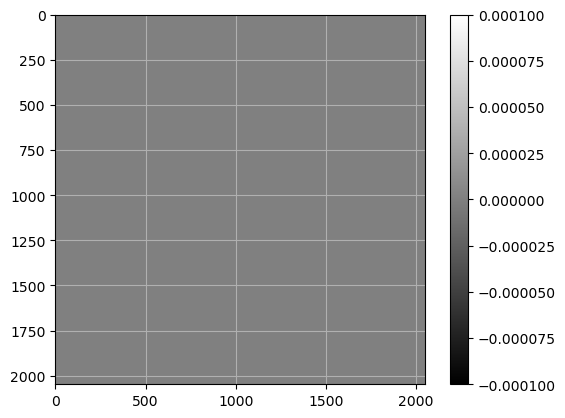

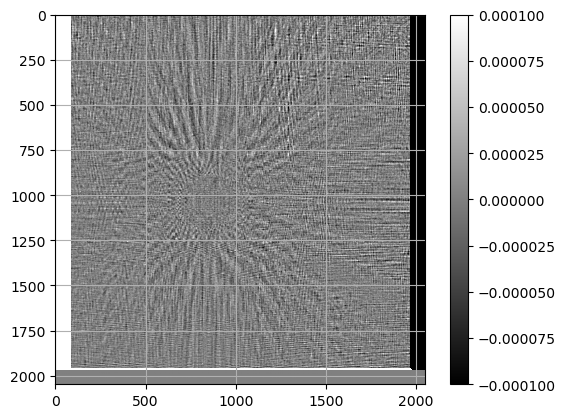

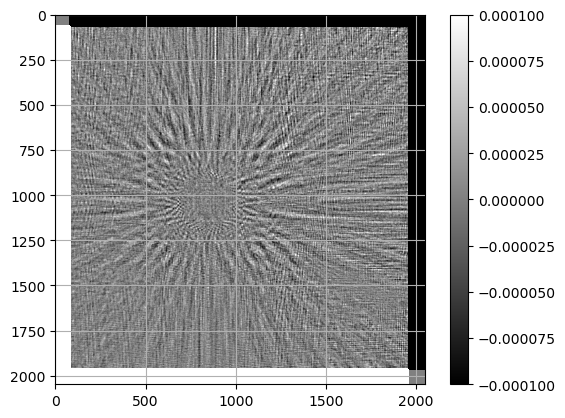

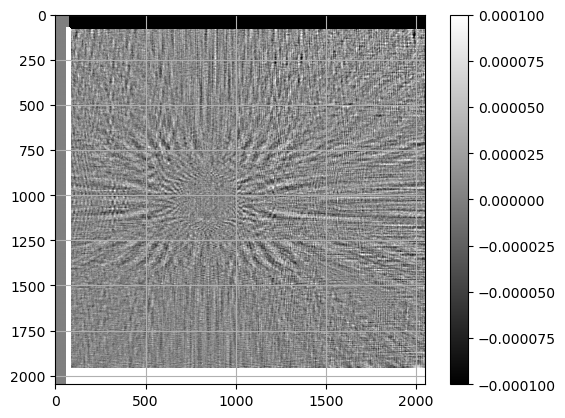

In [6]:
for k in range(npos):
    rdata[:,k] = ST(rdata[:,k],shifts_code[:,k])

for k in range(0,npos,4):
    mshow(rdata[0,k]-rdata[0,0],show,vmin=-1e-4,vmax=1e-4)
    plt.grid('on')
    plt.colorbar()
    plt.show()

# Construct operators


In [7]:
def Lop(psi):
    psi = cp.array(psi)

    data = cp.zeros([psi.shape[0], npos, n, n], dtype='complex64')
    for i in range(npos):
        psir = psi[:,i].copy()       
        psir = G(psir, wavelength, voxelsize, distances[i])
        data[:, i] = psir[:, pad:n+pad, pad:n+pad]
    return data

def LTop(data):
    psi = cp.zeros([data.shape[0],npos, n+2*pad, n+2*pad], dtype='complex64')

    for j in range(npos):
        psir = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad))).astype('complex64')
        psir = GT(psir, wavelength, voxelsize, distances[j])        
        psi[:,j] = psir
    return psi

def Sop(psi):
    psi = cp.array(psi)

    data = cp.zeros([psi.shape[0], npos, n+2*pad, n+2*pad], dtype='complex64')
    for i in range(npos):
        psir = psi.copy()
    
        # shift and crop the code 
        psir = S(psir, shifts_code[:, i])
        nee = psir.shape[1]        
        data[:,i] = psir[:, nee//2-n//2-pad:nee//2+n//2+pad, nee//2-n//2-pad:nee//2+n//2+pad]
    return data

def STop(data):
    psi = cp.zeros([data.shape[0], ne, ne], dtype='complex64')

    for j in range(npos):
        psir = cp.pad(data[:,j],((0,0),(ne//2-n//2-pad,ne//2-n//2-pad),(ne//2-n//2-pad,ne//2-n//2-pad)))        
        psi += ST(psir,shifts_code[:,j])
    return psi


data = cp.array(data00)
arr1 = cp.pad(data[:,0],((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'symmetric')     
prb1 = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
shifts_code = cp.array(shifts_code)
arr2 = Sop(arr1)
arr3 = STop(arr2)

arr4 = Lop(arr2)
arr5 = LTop(arr4)


print(f'{cp.sum(arr1*cp.conj(arr3))}==\n{cp.sum(arr2*cp.conj(arr2))}')
print(f'{cp.sum(arr2*cp.conj(arr5))}==\n{cp.sum(arr4*cp.conj(arr4))}')



(126721688-4.491238594055176j)==
(126721696-1.0132281819119626e-10j)
(83255336-2.90234375j)==
(83255344+2.5532721338095143e-05j)


### Divide by reference image for 1step Paganin reconsturction

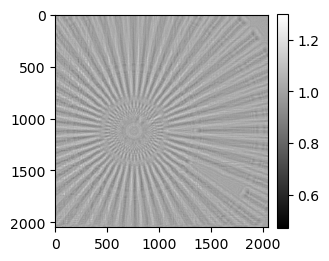

In [8]:
ref0 = cp.array(cp.mean(ref00,axis=0))[np.newaxis,np.newaxis]
data00 = cp.array(data00)
rdata = data00/ref0
mshow((rdata)[0,0],show,vmax=1.3)

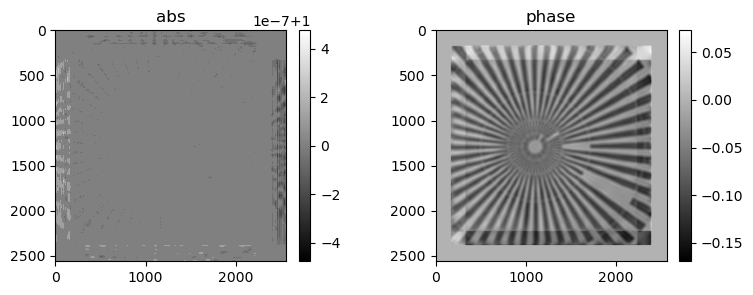

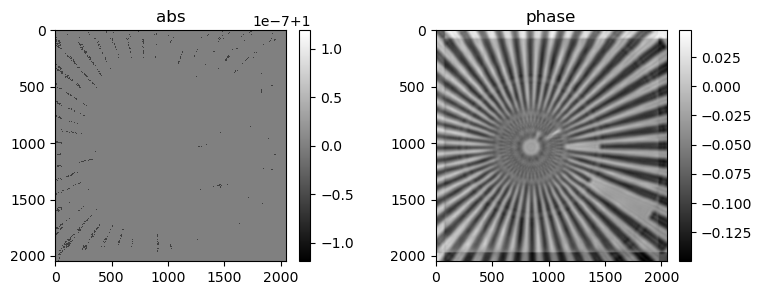

In [9]:
recMultiPaganin = cp.zeros([1,npos,ne,ne],dtype='complex64')
recMultiPaganinr = cp.zeros([1,npos,ne,ne],dtype='complex64')# to compensate for overlap
for j in range(0,npos):
    r = multiPaganin(rdata[:,j:j+1],
                         distances[j:j+1], wavelength, voxelsize,  24.05, 9e-3)    
    rr = r*0+1 # to compensate for overlap
    r = cp.pad(r,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)),'constant')   
    rr = cp.pad(rr,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)),'constant')   
    recMultiPaganin[:,j] = ST(r,shifts_code[:,j])
    recMultiPaganinr[:,j] = ST(rr,shifts_code[:,j])
    
recMultiPaganin = cp.sum(recMultiPaganin,axis=1)
recMultiPaganinr = cp.sum(recMultiPaganinr,axis=1)

# avoid division by 0
recMultiPaganinr[np.abs(recMultiPaganinr)<5e-2] = 1

# compensate for overlap
recMultiPaganin /= recMultiPaganinr
recMultiPaganin = cp.exp(1j*recMultiPaganin)

mshow_polar(recMultiPaganin[0],show)
mshow_polar(recMultiPaganin[0,pad:-pad,pad:-pad],show)


#### Reconstruction with the CG (Carlsson) with Hessians

0) alpha=0.02001, err=4.03002e+05


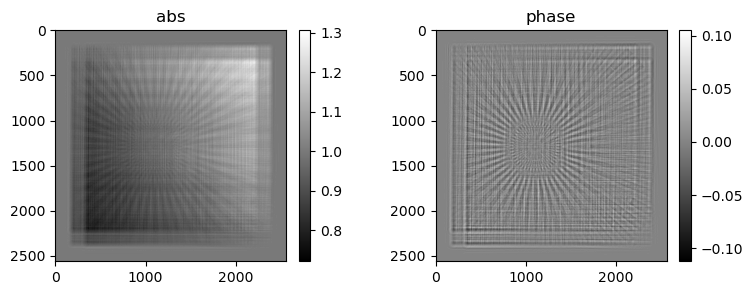

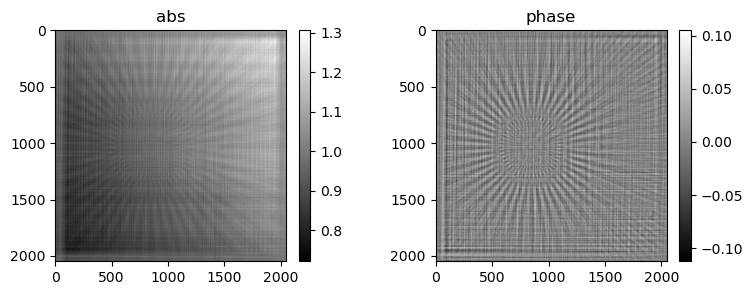

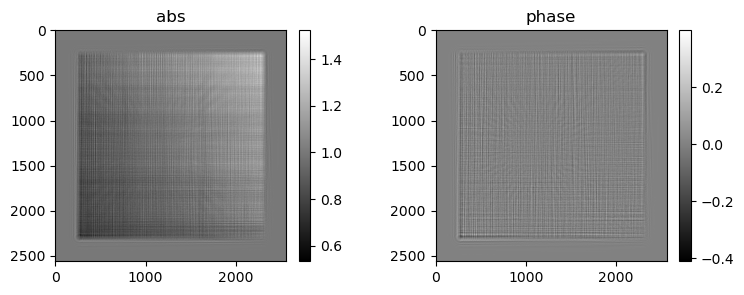

/data/vnikitin/ESRF/ID16A/SiemensLH_33keV_010nm_holoNfpScan_01//rec/rec_psi_1_000.tiff
1) alpha=0.02425, err=7.58701e+04
2) alpha=0.02453, err=3.28138e+04
3) alpha=0.02693, err=2.19817e+04
4) alpha=0.03634, err=1.87679e+04
5) alpha=0.04127, err=1.72221e+04
6) alpha=0.04106, err=1.61933e+04
7) alpha=0.04804, err=1.52528e+04
8) alpha=0.04872, err=1.44871e+04
9) alpha=0.04630, err=1.38668e+04
10) alpha=0.04658, err=1.33848e+04
11) alpha=0.04954, err=1.29571e+04
12) alpha=0.05151, err=1.25485e+04
13) alpha=0.05679, err=1.21104e+04
14) alpha=0.05476, err=1.16632e+04
15) alpha=0.04900, err=1.12259e+04
16) alpha=0.04744, err=1.08254e+04


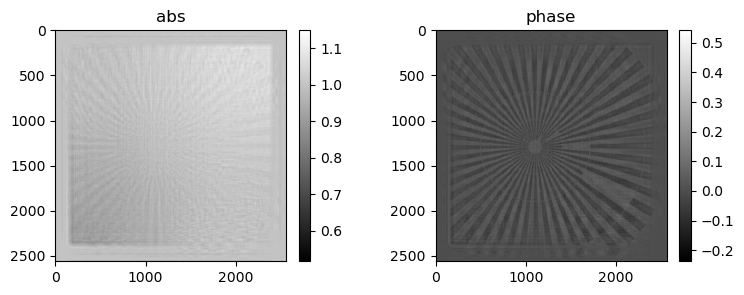

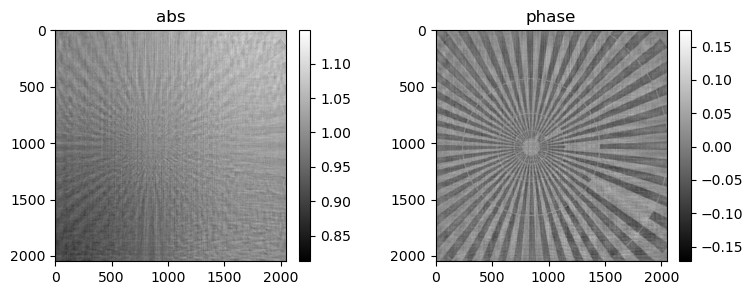

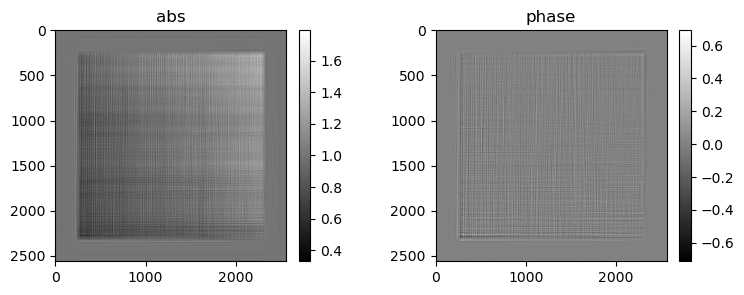

/data/vnikitin/ESRF/ID16A/SiemensLH_33keV_010nm_holoNfpScan_01//rec/rec_psi_1_016.tiff


In [10]:
def redot(a,b):
    return cp.sum(a.real*b.real+a.imag*b.imag)

def hessian2(Lpsi,Lpsi1,Lpsi2,data):
    l0 = Lpsi/cp.abs(Lpsi)
    d0 = data/cp.abs(Lpsi)
    v1 = redot(1-d0,cp.real(Lpsi1*cp.conj(Lpsi2)))
    v2 = redot(d0,cp.real(cp.conj(l0)*Lpsi1)*cp.real(cp.conj(l0)*Lpsi2))
    return 2*(v1+v2)

def minf(fpsi,data):
    f = np.linalg.norm(np.abs(fpsi)-data)**2
    return f

def cg_holo(data, init_psi,init_prb,  pars):
    
    data = np.sqrt(data)
    
    psi = init_psi.copy()
    prb = init_prb.copy()

    erra = np.zeros(pars['niter'])
    alphaa = np.zeros(pars['niter'])
    
    for i in range(pars['niter']):                                        
        
        Lpsi = Lop(Sop(psi)*prb)                
        gradx = 2*LTop(Lpsi-data*(Lpsi/cp.abs(Lpsi)))  
        
        gradpsi = STop(gradx*cp.conj(prb))                     
        gradprb = cp.sum(gradx*cp.conj(Sop(psi)),axis=1)
        
        if i==0:
            etapsi = -gradpsi
            etaprb = -gradprb
        else:
            Lpsi = Lop(Sop(psi)*prb)            
            Lksi = Lop(Sop(gradpsi)*prb+Sop(psi)*gradprb)   
            Leta = Lop(Sop(etapsi)*prb+Sop(psi)*etaprb)     
            # top
            top = hessian2(Lpsi,Lksi,Leta,data)
            top += redot(gradx,Sop(gradpsi)*etaprb+Sop(etapsi)*gradprb)
            # bottom
            bottom = hessian2(Lpsi,Leta,Leta,data)
            bottom += 2*redot(gradx,Sop(etapsi)*etaprb)

            beta = top/bottom
            
            etapsi = -gradpsi + beta*etapsi
            etaprb = -gradprb + beta*etaprb

        #top
        top = -redot(gradpsi,etapsi)-redot(gradprb,etaprb)
        # bottom
        Lpsi = Lop(Sop(psi)*prb)
        Leta = Lop(Sop(etapsi)*prb+Sop(psi)*etaprb)
        
        bottom = hessian2(Lpsi,Leta,Leta,data)
        bottom += 2*redot(gradx,Sop(etapsi)*etaprb)
        
        alpha = top/bottom

        psi += alpha*etapsi
        prb += alpha*etaprb

        if i % pars['err_step'] == 0:
            fpsi = Lop(Sop(psi)*prb)
            err = minf(fpsi,data)
            erra[i] = err
            alphaa[i] = alpha
            print(f'{i}) {alpha=:.5f}, {err=:1.5e}')

        if i % pars['vis_step'] == 0 and pars['vis_step']>0 :
            mshow_polar(psi[0],show)
            mshow_polar(psi[0,pad:-pad,pad:-pad],show)
            mshow_polar(prb[0],show)
            dxchange.write_tiff(cp.angle(psi).get(),f'{path}/rec/rec_psi_ang_{flg}_{i:03}',overwrite=True)
            dxchange.write_tiff(cp.angle(prb).get(),f'{path}/rec/rec_prb_ang_{flg}_{i:03}',overwrite=True)
            dxchange.write_tiff(cp.abs(psi).get(),f'{path}/rec/rec_psi_abs_{flg}_{i:03}',overwrite=True)
            dxchange.write_tiff(cp.abs(prb).get(),f'{path}/rec/rec_prb_abs_{flg}_{i:03}',overwrite=True)
            print(f'{path}/rec/rec_psi_{flg}_{i:03}.tiff')

    return psi,prb,erra,alphaa

# fully on gpu
rec_psi = cp.ones([1,ne,ne],dtype='complex64')#recMultiPaganin.copy()*0+1
data = cp.array(data00.copy())

rec_prb = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
pars = {'niter':257, 'err_step': 1, 'vis_step': 16}
rec_psi,rec_prb,erra,alphaa = cg_holo(data,rec_psi,rec_prb, pars)